In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# File paths
dga_file = "/home/ubuntu/DoH_DGA_training/datasets/DGA/all_pcaps.csv"
tunnel_file = "/home/ubuntu/DoH_DGA_training/datasets/DoH_HKD/DoH-Pcaps/DoH-Pcaps-dnstt/dnstt_all_pcaps.csv"

# Load datasets
df_dga = pd.read_csv(dga_file)
df_tunnel = pd.read_csv(tunnel_file)

# Assign labels
df_dga["label"] = "DGA"
df_tunnel["label"] = "tunnel"

print("DGA shape:", df_dga.shape)
print("Tunnel shape:", df_tunnel.shape)

# Print columns to confirm structure
print("Columns:\n", list(df_dga.columns))


DGA shape: (2256, 25)
Tunnel shape: (1198, 25)
Columns:
 ['flow_id', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'n_sent', 'sent_bytes', 'sent_pkt_min', 'sent_pkt_mean', 'sent_pkt_max', 'sent_iat_min', 'sent_iat_mean', 'sent_iat_max', 'n_recv', 'recv_bytes', 'recv_pkt_min', 'recv_pkt_mean', 'recv_pkt_max', 'recv_iat_min', 'recv_iat_mean', 'recv_iat_max', 'server_delay', 'bytes_ratio', 'label']


In [3]:
# Concatenate into one dataframe
final_df = pd.concat([df_dga, df_tunnel], ignore_index=True)

print("Final dataset shape:", final_df.shape)
print(final_df["label"].value_counts())

# Separate features and target
y = final_df["label"]
X = final_df.drop(columns=["label", 'flow_id', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'n_recv', 'n_sent'])

# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Features shape:", X.shape)


Final dataset shape: (3454, 25)
label
DGA       2256
tunnel    1198
Name: count, dtype: int64
Features shape: (3454, 16)


In [4]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    max_iter=50,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_scaled, y_train)


Iteration 1, loss = 0.51303475
Iteration 2, loss = 0.31185341
Iteration 3, loss = 0.20079850
Iteration 4, loss = 0.13419192
Iteration 5, loss = 0.09228200
Iteration 6, loss = 0.06197896
Iteration 7, loss = 0.04059299
Iteration 8, loss = 0.02739269
Iteration 9, loss = 0.01883653
Iteration 10, loss = 0.01354872
Iteration 11, loss = 0.01011520
Iteration 12, loss = 0.00772357
Iteration 13, loss = 0.00614574
Iteration 14, loss = 0.00500830
Iteration 15, loss = 0.00421120
Iteration 16, loss = 0.00362659
Iteration 17, loss = 0.00314268
Iteration 18, loss = 0.00279966
Iteration 19, loss = 0.00248510
Iteration 20, loss = 0.00224222
Iteration 21, loss = 0.00200900
Iteration 22, loss = 0.00181822
Iteration 23, loss = 0.00162394
Iteration 24, loss = 0.00150975
Iteration 25, loss = 0.00132086
Iteration 26, loss = 0.00119608
Iteration 27, loss = 0.00109184
Iteration 28, loss = 0.00101416
Iteration 29, loss = 0.00096932
Iteration 30, loss = 0.00085261
Iteration 31, loss = 0.00077138
Iteration 32, los

,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,50
,shuffle,True
,random_state,42


In [6]:
y_pred = mlp.predict(X_test_scaled)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

         DGA       1.00      1.00      1.00       451
      tunnel       1.00      1.00      1.00       240

    accuracy                           1.00       691
   macro avg       1.00      1.00      1.00       691
weighted avg       1.00      1.00      1.00       691


Confusion Matrix:

[[451   0]
 [  0 240]]


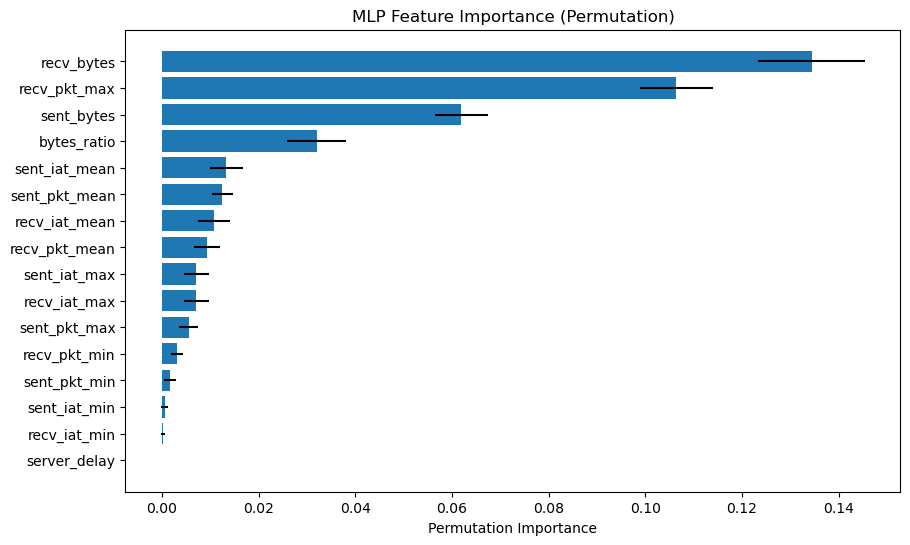

In [11]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Compute permutation importance on test set
result = permutation_importance(
    mlp, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("MLP Feature Importance (Permutation)")
plt.show()


In [21]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

clf = CatBoostClassifier(
    iterations=1,       # similar to n_estimators
    depth=5,           # similar to max_depth
    max_leaves=32,
    learning_rate=0.1,
    random_seed=42,
    verbose=0,          # suppress training logs
    thread_count=-1     # use all CPU cores
)

clf.fit(X_train, y_train)
clf.save_model("catboost_model.json", format="json")

y_pred = clf.predict(X_test)

print("=== CatBoost ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))


=== CatBoost ===
              precision    recall  f1-score   support

         DGA       1.00      0.99      1.00       451
      tunnel       0.99      1.00      0.99       240

    accuracy                           1.00       691
   macro avg       0.99      1.00      1.00       691
weighted avg       1.00      1.00      1.00       691



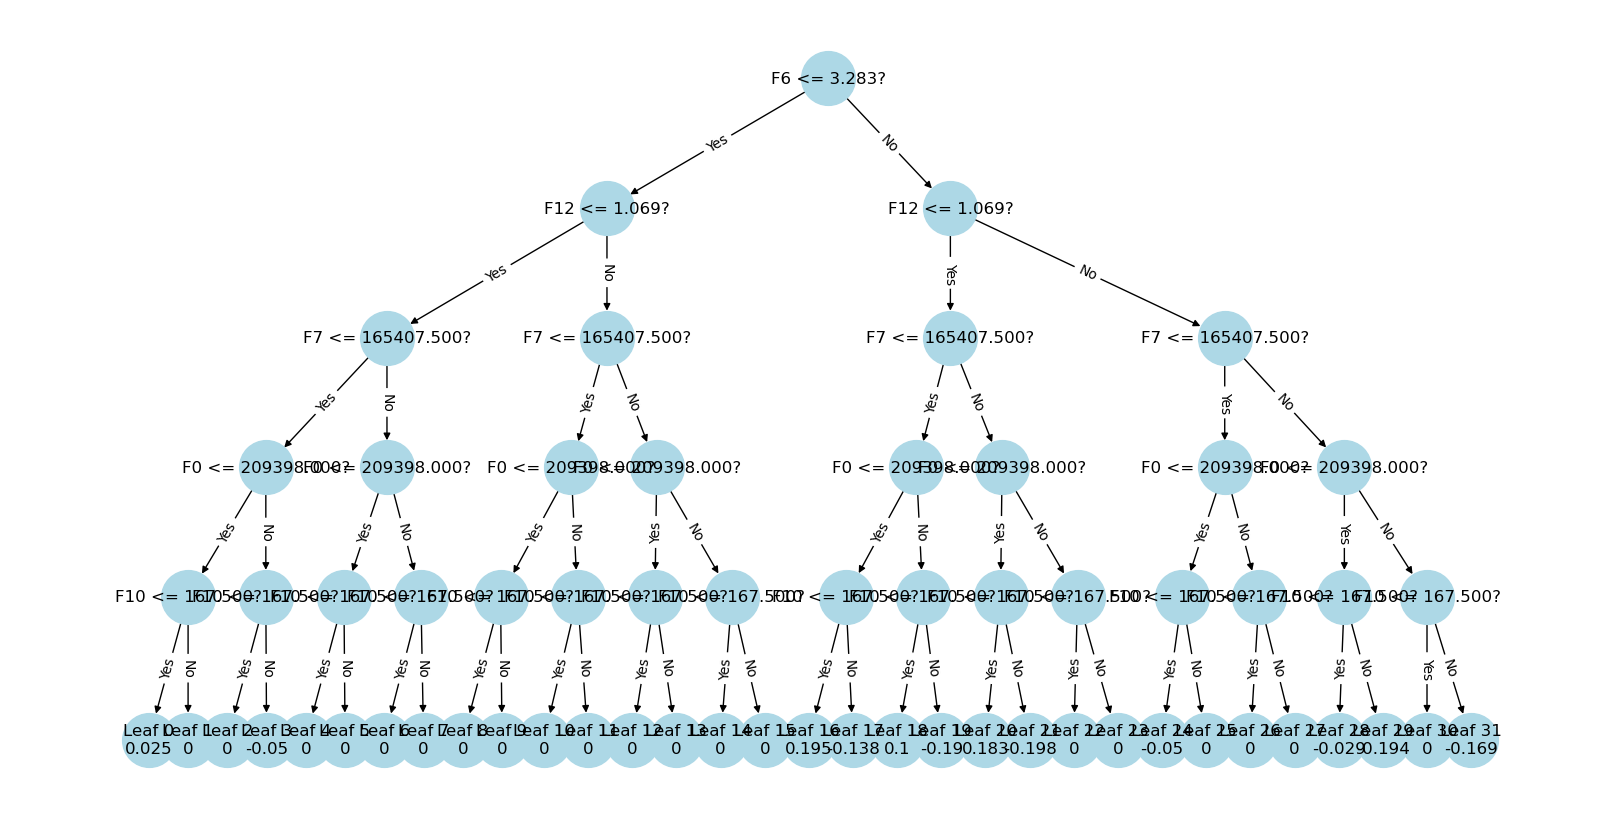

In [22]:
import json
import matplotlib.pyplot as plt
import networkx as nx

# load JSON
with open("catboost_model.json", "r") as f:
    model = json.load(f)

tree = model["oblivious_trees"][0]
splits = tree["splits"]
leaf_values = tree["leaf_values"]

depth = len(splits)   # 6
n_leaves = len(leaf_values)  # 64

# Build a graph
G = nx.DiGraph()

def add_nodes(node_id, depth_level, path_bits):
    if depth_level == depth:
        leaf_index = int("".join(str(b) for b in path_bits), 2)
        val = round(leaf_values[leaf_index], 3)
        G.add_node(node_id, label=f"Leaf {leaf_index}\n{val}")
        return

    split = splits[depth_level]
    feat = split["float_feature_index"]
    border = split["border"]

    G.add_node(node_id, label=f"F{feat} <= {border:.3f}?")

    left_id = f"{node_id}L"
    right_id = f"{node_id}R"

    G.add_edge(node_id, left_id, label="Yes")
    G.add_edge(node_id, right_id, label="No")

    add_nodes(left_id, depth_level+1, path_bits+[0])
    add_nodes(right_id, depth_level+1, path_bits+[1])

add_nodes("root", 0, [])

# Draw
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(16, 8))
nx.draw(G, pos, with_labels=False, node_size=1500, node_color="lightblue")
nx.draw_networkx_labels(G, pos, labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis("off")
plt.show()


In [23]:
import math
import json

# Range of raw scores you want to cover
start = -0.5
end   = 2.5
step  = 0.01   # resolution of table

def sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-x))

# Precompute table
values = [round(sigmoid(x), 6) for x in [start + i*step for i in range(int((end-start)/step)+1)]]

# Print a few
for i, v in enumerate(values[:20]):
    print(f"{start + i*step:.2f} -> {v}")

-0.50 -> 0.377541
-0.49 -> 0.379894
-0.48 -> 0.382252
-0.47 -> 0.384616
-0.46 -> 0.386986
-0.45 -> 0.389361
-0.44 -> 0.391741
-0.43 -> 0.394126
-0.42 -> 0.396517
-0.41 -> 0.398912
-0.40 -> 0.401312
-0.39 -> 0.403717
-0.38 -> 0.406127
-0.37 -> 0.408541
-0.36 -> 0.41096
-0.35 -> 0.413382
-0.34 -> 0.415809
-0.33 -> 0.418241
-0.32 -> 0.420676
-0.31 -> 0.423115
